In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import os

path ="./BrainMRI/Testing/"
#we shall store all the file names in this list
filelist = []

for root, dirs, files in os.walk(path):
	for file in files:
        #append the file name to the list
		filelist.append(os.path.join(root,file))


In [3]:
filelist[:10]

['./BrainMRI/Testing/pituitary_tumor/image(76).jpg',
 './BrainMRI/Testing/pituitary_tumor/image(67).jpg',
 './BrainMRI/Testing/pituitary_tumor/image(15).jpg',
 './BrainMRI/Testing/pituitary_tumor/image(8).jpg',
 './BrainMRI/Testing/pituitary_tumor/image(96).jpg',
 './BrainMRI/Testing/pituitary_tumor/image(57).jpg',
 './BrainMRI/Testing/pituitary_tumor/image(87).jpg',
 './BrainMRI/Testing/pituitary_tumor/image(31).jpg',
 './BrainMRI/Testing/pituitary_tumor/image(56).jpg',
 './BrainMRI/Testing/pituitary_tumor/image(91).jpg']

In [4]:
def get_label(img_path):
    img_label = img_path.split('/')
    return img_label[-2]
    

In [5]:
image_labels = []
for i in range(len(filelist)):
    img_labels = get_label(filelist[i])
    image_labels.append(img_labels)

In [6]:
filenames = pd.Series(filelist)

In [7]:
labels = pd.Series(image_labels)

In [8]:
tumor_test_df = pd.DataFrame({'filenames':filelist,
                         'label':labels})

In [9]:
tumor_test_df

,filenames,label
0,./BrainMRI/Testing/pituitary_tumor/image(76).jpg,pituitary_tumor
1,./BrainMRI/Testing/pituitary_tumor/image(67).jpg,pituitary_tumor
2,./BrainMRI/Testing/pituitary_tumor/image(15).jpg,pituitary_tumor
3,./BrainMRI/Testing/pituitary_tumor/image(8).jpg,pituitary_tumor
4,./BrainMRI/Testing/pituitary_tumor/image(96).jpg,pituitary_tumor
...,...,...
389,./BrainMRI/Testing/glioma_tumor/image(55).jpg,glioma_tumor
390,./BrainMRI/Testing/glioma_tumor/image(39).jpg,glioma_tumor
391,./BrainMRI/Testing/glioma_tumor/image(18).jpg,glioma_tumor
392,./BrainMRI/Testing/glioma_tumor/image(82).jpg,glioma_tumor


In [10]:
X_test = tumor_test_df['filenames']
y_test = tumor_test_df['label']

In [11]:
# Define image size
IMG_SIZE = 32

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [12]:
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [13]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


In [14]:
class_names = ['pituitary_tumor', 'meningioma_tumor', 'no_tumor', 'glioma_tumor']

In [25]:
test_ds = create_data_batches(X=X_test , y = y_test , test_data=True)

Creating test data batches...


In [16]:
from tensorflow import keras
model = keras.models.load_model('./')

In [17]:
y_probs = model.predict(test_ds)

2022-09-03 12:00:21.169554: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-03 12:00:22.575245: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-03 12:00:22.654498: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-03 12:00:22.654560: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-03 12:00:22.706067: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-03 12:00:22.706182: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


13/13 [==============================] - 6s 32ms/step


In [18]:
y_probs

array([[1.5856322e-08, 9.9999821e-01, 1.3699698e-06, 4.2104318e-07],
       [1.4070481e-01, 6.3262033e-01, 2.2629748e-01, 3.7728445e-04],
       [9.9066329e-01, 8.3329091e-05, 9.1769248e-03, 7.6401178e-05],
       ...,
       [1.0107687e-08, 2.3384655e-07, 9.9999976e-01, 2.3398450e-10],
       [1.4249848e-08, 1.0741000e-03, 9.9892586e-01, 7.4004545e-09],
       [1.4583282e-11, 9.7973107e-08, 9.9999988e-01, 1.6508604e-08]],
      dtype=float32)

In [19]:
import tensorflow as tf

In [20]:
y_preds = tf.argmax(y_probs,axis=1)

In [21]:
y_preds[:20].numpy()

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 2, 0, 1, 1])

In [22]:
np.array(y_test[:20])

array(['pituitary_tumor', 'pituitary_tumor', 'pituitary_tumor',
       'pituitary_tumor', 'pituitary_tumor', 'pituitary_tumor',
       'pituitary_tumor', 'pituitary_tumor', 'pituitary_tumor',
       'pituitary_tumor', 'pituitary_tumor', 'pituitary_tumor',
       'pituitary_tumor', 'pituitary_tumor', 'pituitary_tumor',
       'pituitary_tumor', 'pituitary_tumor', 'pituitary_tumor',
       'pituitary_tumor', 'pituitary_tumor'], dtype=object)

In [23]:
class_names[y_preds[0].numpy().tolist()]

'meningioma_tumor'

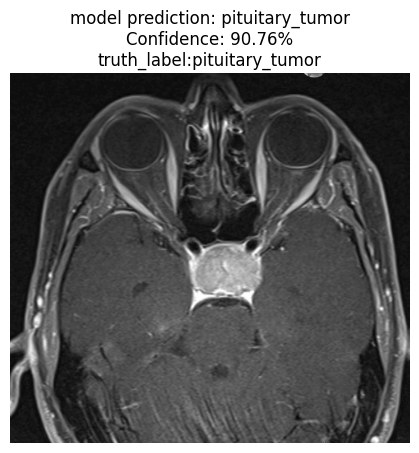

In [52]:
import random
index = random.randint(0,len(X_test))
def show_img(img_path,index=index):

    img = plt.imread(img_path)
    img = plt.imshow(img)
    preds = class_names[y_preds[index].numpy().tolist()]
    confidence = round(np.max(y_probs[index])*100,2)
    plt.title('model prediction: '+preds +'\n'+'Confidence: '+str(confidence)+'%'+'\n'+ 'truth_label:'+ y_test[index])
       # print(confidence)
    plt.axis('off')
    return img
show_img(X_test[index]);